# Principal Patterns Paper Plots - Main Figures

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pypsa
import os
import sys
import geopandas
import tables
import matplotlib
from operator import itemgetter, attrgetter
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from sklearn.preprocessing import Normalizer

## Helper functions

In [2]:
## from RD_func.py import PCA, MAP
def PCA(X):
    """
    Input:
        - X: Matrix for performing PCA on
    Output:
        - eigen_values:         Eigen values for the input
        - eigen_vectors:        Eigen vectors for the input
        - variance_explained:   How much of the variance is explained by each principal component
        - norm_const:           Normalization constant
        - T:                    Principle component amplitudes (a_k from report)
    """
    X_avg = np.mean(X, axis=0)
    B = X.values - X_avg.values
    norm_const = (1 / (np.sqrt( np.sum( np.mean( ( (X - X_avg)**2 ), axis=0 ) ) ) ) )
    C = np.cov((B*norm_const).T)
    eigen_values, eigen_vectors = np.linalg.eig(C)
    variance_explained = (eigen_values * 100 ) / eigen_values.sum()
    T = np.dot((B*norm_const), eigen_vectors)

    return (eigen_values, eigen_vectors, variance_explained, norm_const, T)

In [3]:
#%% Season plot
def season_plot(T, time_index, file_name):
    """
    Parameters
    ----------
    T : Matrix
        Principle component amplitudes. Given by: B*eig_val (so the centered and scaled data dotted with the eigen values)
    data_index : panda index information
        index for a year (used by panda's dataframe')
    file_name: array of strings
        Name of the datafile there is worked with

    Returns
    -------
    Plot of seasonal distribution
    """
    T = pd.DataFrame(data=T,index=time_index)
    T_avg_hour = T.groupby(time_index.hour).mean() # Hour
    T_avg_day = T.groupby([time_index.month,time_index.day]).mean() # Day

    # Upper left figure
    plt.figure(figsize=(16,10))
    plt.subplot(2,2,1)
    plt.plot(T_avg_hour[0],label='k=1')
    plt.plot(T_avg_hour[1],label='k=2')
    plt.plot(T_avg_hour[2],label='k=3')
    plt.xticks(ticks=range(0,24,2))
    plt.legend(loc='upper right',bbox_to_anchor=(1,1))
    plt.xlabel("Hours")
    plt.ylabel("a_k interday")
    plt.title("Hourly average for k-values for 2015 ")
    # Upper right figure
    x_ax = range(len(T_avg_day[0])) # X for year plot
    plt.subplot(2,2,2)
    plt.plot(x_ax,T_avg_day[0],label='k=1')
    plt.plot(x_ax,T_avg_day[1],label='k=2')
    plt.plot(x_ax,T_avg_day[2],label='k=3')
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.xlabel("day")
    plt.ylabel("a_k seasonal")
    plt.title("daily average for k-values for 2015 ")
    # Lower left figure
    plt.subplot(2,2,3)
    plt.plot(T_avg_hour[3],label='k=4',color="c")
    plt.plot(T_avg_hour[4],label='k=5',color="m")
    plt.plot(T_avg_hour[5],label='k=6',color="y")
    plt.xticks(ticks=range(0,24,2))
    plt.legend(loc='upper right',bbox_to_anchor=(1,1))
    plt.xlabel("Hours")
    plt.ylabel("a_k interday")
    plt.title("Hourly average for k-values for 2015 ")
    # Lower right figure
    x_ax = range(len(T_avg_day[0])) # X for year plot
    plt.subplot(2,2,4)
    plt.plot(x_ax,T_avg_day[3],label='k=4',color="c")
    plt.plot(x_ax,T_avg_day[4],label='k=5',color="m")
    plt.plot(x_ax,T_avg_day[5],label='k=6',color="y")
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.xlabel("day")
    plt.ylabel("a_k seasonal")
    plt.title("daily average for k-values for 2015 ")
    # Figure title
    plt.suptitle(file_name,fontsize=20,x=.51,y=0.932) #,x=.51,y=1.07
    
    return plt.show(all)

In [4]:
#%% Eigen values contribution plot
def eig_val_contribution_plot(lambda_collect_wmin, lambda_tot, file_name):
    """
    Parameters
    ----------
    lambda_collect_wmin : array
        Lambda array collected with those that are minus already included
    lambda_tot : value
        Sum of all lambda values
    file_name : array of strings
        Name of the datafile there is worked with

    Returns
    -------
    Plot of eigen value contribution
    """
    plt.figure(figsize=[14,16])
    for n in range(6):
        lambda_collect_procent = lambda_collect_wmin[n:n+1]/lambda_tot[n]*100 # percentage
        #lambda_collect_procent = lambda_collect_wmin[n:n+1]/lambda_tot[n]*100 # relative
        plt.subplot(3,2,n+1)
        plt.bar(lambda_collect_wmin.columns,lambda_collect_procent.values[0])
        plt.title('PC'+str(n+1)+': '+str(round(lambda_tot[n],3)))
        plt.ylabel('Influance [%]')
        plt.ylim([-50,125])
        plt.grid(axis='y',alpha=0.5)
        for k in range(10):
            if lambda_collect_procent.values[:,k] < 0:
                v = lambda_collect_procent.values[:,k] - 6.5
            else:
                v = lambda_collect_procent.values[:,k] + 2.5
            plt.text(x=k,y=v,s=str(round(float(lambda_collect_procent.values[:,k]),2))+'%',ha='center',size='small')
    plt.suptitle(file_name,fontsize=20,x=.51,y=0.92) #,x=.51,y=1.07     
   
    return plt.show(all)

In [5]:
#%% Principle component contribution plot
def PC_contribution_plot(PC_con, type_of_contribution):
    """
    Parameters
    ----------
    PC_con : list
        list of with sorted principle components contributions 
    type_of_contribution : string
        "mismatch" - used when wanting to plot for the mismatch case
        "respone" - used when wanting to plot for the response case
    
    Returns
    -------
    Plot of principle component distribution
    """
    plt.figure(figsize=(14,16))#,dpi=500)
    for i in range(6):
        if type_of_contribution == "mismatch":
            # y functions comulated
            wind_con_data  = PC_con[i][:,:1].sum(axis=1)
            solar_con_data = PC_con[i][:,:2].sum(axis=1)
            hydro_con_data = PC_con[i][:,:3].sum(axis=1)
            load_con_data  = PC_con[i][:,:4].sum(axis=1)
            gen_cov_data   = PC_con[i][:,:7].sum(axis=1)
            load_cov_data  = PC_con[i][:,8:10].sum(axis=1)
            # plot function
            plt.subplot(3,2,i+1)
            # Plot lines
            plt.plot(wind_con_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(solar_con_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(hydro_con_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(load_con_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(gen_cov_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(load_cov_data,color='k',alpha=1,linewidth=0.5)
            # Plot fill inbetween lines
            plt.fill_between(range(7), np.zeros(7), wind_con_data,
                             label='Wind',
                             color='cornflowerblue') # Because it is a beutiful color
            plt.fill_between(range(7), wind_con_data, solar_con_data,
                             label='Solar',
                             color='yellow')
            plt.fill_between(range(7), solar_con_data, hydro_con_data,
                             label='Hydro',
                             color='darkslateblue')
            plt.fill_between(range(7), hydro_con_data, load_con_data,
                             label='Load',
                             color='slategray')
            plt.fill_between(range(7), load_con_data, gen_cov_data,
                             label='Generator\ncovariance',
                             color='brown',
                             alpha=0.5)
            plt.fill_between(range(7), load_cov_data, np.zeros(7),
                             label='Load\ncovariance',
                             color='orange',
                             alpha=0.5)
            # y/x-axis and title
            #plt.legend(bbox_to_anchor = (1,1))
            plt.ylabel('$\lambda_k$')
            plt.xticks(np.arange(0,7),['40%', '50%', '60%', '70%', '80%', '90%', '95%'])
            plt.title('Principle component '+str(i+1))
            if i == 4: # Create legend of figure 4 (lower left)
                plt.legend(loc = 'center', bbox_to_anchor = (1.1,-0.17), ncol = 6, 
                           fontsize = 'large', framealpha = 1, columnspacing = 2.5)
        
        # Principle components for nodal response
        elif type_of_contribution == "response": 
            # y functions comulated
            backup_con_data  = PC_con[i][:,:1].sum(axis=1)
            inport_export_con_con_data = PC_con[i][:,:2].sum(axis=1)
            storage_con_data = PC_con[i][:,:3].sum(axis=1)
            #backup_inport_cov_data  = PC_con[i][:,:4].sum(axis=1)
            #backup_store_cov_data   = PC_con[i][:,:5].sum(axis=1)
            inport_store_cov_data   = PC_con[i][:,:6].sum(axis=1)
            # plot function
            plt.subplot(3,2,i+1)
            # Plot lines
            plt.plot(backup_con_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(inport_export_con_con_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(storage_con_data,color='k',alpha=1,linewidth=0.5)
            plt.plot(inport_store_cov_data,color='k',alpha=1,linewidth=0.5)
            plt.fill_between(range(7), np.zeros(7), backup_con_data,
                             label='backup',
                             color='cornflowerblue') # Because it is a beutiful color
            plt.fill_between(range(7), backup_con_data, inport_export_con_con_data,
                             label='import & export',
                             color='yellow')
            plt.fill_between(range(7), inport_export_con_con_data, storage_con_data,
                             label='storage',
                             color='darkslateblue')
            plt.fill_between(range(7), storage_con_data, inport_store_cov_data,
                             label='covariance',
                             color='orange',
                             alpha=0.5)
            plt.ylabel('$\lambda_k$')
            plt.xticks(np.arange(0,7),['40%', '50%', '60%', '70%', '80%', '90%', '95%'])
            plt.title('Principle component '+str(i+1))
            if i == 4: # Create legend of figure 4 (lower left)
                plt.legend(loc = 'center', bbox_to_anchor = (1.1,-0.17), ncol = 6,
                           fontsize = 'large', framealpha = 1, columnspacing = 2.5)     
            else:
                assert True, "type_of_contribution not used correct"

    return plt.show(all)

In [6]:
def MAP(eigen_vectors, eigen_values, data_names, PC_NO, title_plot, filename_plot):
    """
    Parameters
    ----------
    eigen_vectors : maxtrix [N x N]
        Eigen vectors.
    eigen_values : matrix [N x 1]
        Eigen values.
    data_names : List of string [N x 30]
        Name of countries ('alpha-2-code' format).
    PC_NO : scalar integer
        Principal component number (starts from 1).
    title_plot : string
        Title of plot.
    filename_plot : string
        Subplot title.

    Returns
    -------
    Plot
        Map plot.
    """
    VT = pd.DataFrame(data=eigen_vectors, index=data_names)
    variance_explained = []
    for i in eigen_values:
         variance_explained.append((i/sum(eigen_values))*100)
    
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=cartopy.crs.TransverseMercator(20))
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
    ax.coastlines(resolution='10m')
    ax.add_feature(cartopy.feature.OCEAN, facecolor=(0.6,0.8,1), alpha=0.30)
    ax.set_extent ((-9.5, 32, 35, 71), cartopy.crs.PlateCarree())
    ax.gridlines()
    
    europe_not_included = {'AD', 'AL','AX','BY', 'FO', 'GG', 'GI', 'IM', 'IS', 
                           'JE', 'LI', 'MC', 'MD', 'ME', 'MK', 'MT', 'RU', 'SM', 
                           'UA', 'VA', 'XK'}
    shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    name_loop = 'start'
    for country in countries:
        if country.attributes['ISO_A2'] in europe_not_included:
            ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=(0.8, 0.8, 0.8), alpha=0.50, linewidth=0.15, 
                              edgecolor="black", label=country.attributes['ADM0_A3'])
        elif country.attributes['REGION_UN'] == 'Europe':
            if country.attributes['NAME'] == 'Norway':
                name_loop = 'NO'
            elif country.attributes['NAME'] == 'France':
                name_loop = 'FR'
            else:
                name_loop = country.attributes['ISO_A2']
            for country_PSA in VT.index.values:
                if country_PSA == name_loop:
                    color_value = VT.loc[country_PSA][PC_NO-1]
                    if color_value <= 0:
                        color_value = np.absolute(color_value)*1.5
                        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=(1, 0, 0), alpha=(np.min([color_value, 1])), 
                                          linewidth=0.15, edgecolor="black", label=country.attributes['ADM0_A3'])
                    else:
                        color_value = np.absolute(color_value)*1.5
                        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=(0, 1, 0), alpha=(np.min([color_value, 1])), 
                                          linewidth=0.15, edgecolor="black", label=country.attributes['ADM0_A3'])
        else:
            ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=(0.8, 0.8, 0.8), alpha=0.50, linewidth=0.15, 
                              edgecolor="black", label=country.attributes['ADM0_A3'])
    
    plt.title(title_plot)
    plt.legend([r'$\lambda_{'+ str(PC_NO) + '}$ = ' + str(round(variance_explained[PC_NO-1],1)) + '%'], loc='upper left')
    test = np.zeros([30,30])
    test[0,0]=-1
    test[0,29]=1
    cmap = LinearSegmentedColormap.from_list('mycmap', [(1,0,0),(1,0,0),(1,0.333,0.333),(1,0.666,0.666), 'white',(0.666,1,0.666),(0.333,1,0.333),(0,1,0),(0,1,0)])
    cax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
    im = ax.imshow(test,cmap=cmap)                
    plt.colorbar(im,cax=cax)
    plt.suptitle(filename_plot,fontsize=20,x=.51,y=0.938)
    
    return (plt.show());

In [7]:
def BAR(matrix, PC_max, filename, constraints, title, xlabel, suptitle):
    """
    Parameters
    ----------
    matrix : list [len(filename) x 1] of lists of float32 [30 x 1]
        Each sub-list contains the eigen values of each case/scenario
    PC_max : integer
        Number of PC showed on barplot, where the last is summed up i.e. 1, 2, 3, (4-30) which is 4 in total (PC_max=4)
    filename : list of strings
        List of filenames. Used to determine how many bars plotted
    constraints : list of strings
        Used as descriptor for x-axis.
    title : string
        Title of the plot.
    xlabel : string
        label for the x-axis beside the constraint i.e. CO2 or Transmission size.
    suptitle : string (optional)
        Subtitle for plot  (above title). Type 'none' for no subtitle.

    Returns
    -------
    plot
        Returns the final plot.
    """
    fig1 = plt.figure()
    ax = fig1.add_axes([0,0,1,1.5])    
    cmap = plt.get_cmap("Paired")
    j_max = PC_max
    colour_map = cmap(np.arange(j_max))
    lns_fig1 = []
    
    for i in np.arange(0,len(filename)):
        for j in np.arange(0,j_max):
            if j == 0:
                lns_plot = ax.bar(constraints[i], matrix[i][j], color=colour_map[j], edgecolor='black', linewidth=1.2, label=('$k_{' + str(j+1) + '}$'))
            elif (j > 0 and j < (j_max-1)):
                lns_plot = ax.bar(constraints[i], matrix[i][j], bottom = sum(matrix[i][0:j]), color=colour_map[j], edgecolor='black', label=('$k_{' + str(j+1) + '}$'))
            else:
                lns_plot = ax.bar(constraints[i], sum(matrix[i][j:29]), bottom = sum(matrix[i][0:j]), color=colour_map[j], edgecolor='black', label=('$k_{' + str(j+1) + '}$ - $k_{30}$'))
            if (i==0):
                lns_fig1.append(lns_plot)

    labs = [l.get_label() for l in lns_fig1]
    ax.legend(lns_fig1, labs, bbox_to_anchor = (1,1))
    plt.yticks(range(0, 120, 25))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Data variance of each PC [%]')
    plt.grid(axis='y')
    if suptitle != 'none':
        plt.suptitle(suptitle, fontsize=20,x=.5,y=1.68)

    return (plt.show());

In [8]:
def FFT_plot(T, file_name):
    """
    Parameters
    ----------
    T : Matrix
        Principle component amplitudes. Given by: B*eig_val (so the centered and scaled data dotted with the eigen values)
    file_name: array of strings
        Name of the datafile there is worked with

    Returns
    -------
    Plot all
    """
    plt.figure(figsize=(18,12))
    plt.subplot(3,2,1)
    freq=np.fft.fftfreq(len(T[0]))  
    FFT=np.fft.fft(T[0])
    FFT[0]=0
    FFT=abs(FFT)/max(abs(FFT))
    plt.plot(1/freq,FFT)
    plt.xscale('log')
    plt.vlines(12,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*7,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*30,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*365,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    #plt.legend(loc='upper right')
    plt.text(10,0.9,"1/2 Day",ha='right')
    plt.text(22,0.9,"Day",ha='right')
    plt.text(22*7,0.9,"Week",ha='right')
    plt.text(22*7*4,0.9,"Month",ha='right')
    plt.text(22*365,0.9,"Year",ha='right')
    plt.xlabel('Hours')
    plt.title('Fourier Power Spectra for PC1')
    
    plt.subplot(3,2,2)
    freq=np.fft.fftfreq(len(T[1]))  
    FFT=np.fft.fft(T[1])
    FFT[0]=0
    FFT=abs(FFT)/max(abs(FFT))
    plt.plot(1/freq,FFT)
    plt.xscale('log')
    plt.vlines(12,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*7,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*30,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*365,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    #plt.legend(loc='upper right')
    plt.text(10,0.9,"1/2 Day",ha='right')
    plt.text(22,0.9,"Day",ha='right')
    plt.text(22*7,0.9,"Week",ha='right')
    plt.text(22*7*4,0.9,"Month",ha='right')
    plt.text(22*365,0.9,"Year",ha='right')
    plt.xlabel('Hours')
    plt.title('Fourier Power Spectra for PC2')
    
    plt.subplot(3,2,3)
    freq=np.fft.fftfreq(len(T[2]))  
    FFT=np.fft.fft(T[2])
    FFT[0]=0
    FFT=abs(FFT)/max(abs(FFT))
    plt.plot(1/freq,FFT)
    plt.xscale('log')
    plt.vlines(12,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*7,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*30,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*365,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    #plt.legend(loc='upper right')
    plt.text(10,0.9,"1/2 Day",ha='right')
    plt.text(22,0.9,"Day",ha='right')
    plt.text(22*7,0.9,"Week",ha='right')
    plt.text(22*7*4,0.9,"Month",ha='right')
    plt.text(22*365,0.9,"Year",ha='right')
    plt.xlabel('Hours')
    plt.title('Fourier Power Spectra for PC3')
    
    plt.subplot(3,2,4)
    freq=np.fft.fftfreq(len(T[3]))  
    FFT=np.fft.fft(T[3])
    FFT[0]=0
    FFT=abs(FFT)/max(abs(FFT))
    plt.plot(1/freq,FFT)
    plt.xscale('log')
    plt.vlines(12,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*7,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*30,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*365,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    #plt.legend(loc='upper right')
    plt.text(10,0.9,"1/2 Day",ha='right')
    plt.text(22,0.9,"Day",ha='right')
    plt.text(22*7,0.9,"Week",ha='right')
    plt.text(22*7*4,0.9,"Month",ha='right')
    plt.text(22*365,0.9,"Year",ha='right')
    plt.xlabel('Hours')
    plt.title('Fourier Power Spectra for PC4')
    
    plt.subplot(3,2,5)
    freq=np.fft.fftfreq(len(T[4]))  
    FFT=np.fft.fft(T[2])
    FFT[0]=0
    FFT=abs(FFT)/max(abs(FFT))
    plt.plot(1/freq,FFT)
    plt.xscale('log')
    plt.vlines(12,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*7,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*30,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*365,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    #plt.legend(loc='upper right')
    plt.text(10,0.9,"1/2 Day",ha='right')
    plt.text(22,0.9,"Day",ha='right')
    plt.text(22*7,0.9,"Week",ha='right')
    plt.text(22*7*4,0.9,"Month",ha='right')
    plt.text(22*365,0.9,"Year",ha='right')
    plt.xlabel('Hours')
    plt.title('Fourier Power Spectra for PC5')
    
    plt.subplot(3,2,6)
    freq=np.fft.fftfreq(len(T[5]))  
    FFT=np.fft.fft(T[3])
    FFT[0]=0
    FFT=abs(FFT)/max(abs(FFT))
    plt.plot(1/freq,FFT)
    plt.xscale('log')
    plt.vlines(12,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*7,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*30,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    plt.vlines(24*365,0,1 ,colors="k", linestyles="dotted",linewidth=2)
    #plt.legend(loc='upper right')
    plt.text(10,0.9,"1/2 Day",ha='right')
    plt.text(22,0.9,"Day",ha='right')
    plt.text(22*7,0.9,"Week",ha='right')
    plt.text(22*7*4,0.9,"Month",ha='right')
    plt.text(22*365,0.9,"Year",ha='right')
    plt.xlabel('Hours')
    plt.title('Fourier Power Spectra for PC6')        
    
    plt.subplots_adjust(wspace=0, hspace=0.28)
    plt.suptitle(file_name,fontsize=20,x=.51,y=0.93) #,x=.51,y=1.07
    
    return plt.show(all)

## Map plots

In [11]:
file = '../data/postnetwork-elec_only_0.125_0.05.h5'
network = pypsa.Network(file)
network.name = file

generation = network.generators_t.p.groupby(network.generators.bus, axis=1).sum()
load = network.loads_t.p_set
mismatch = generation - load

X = mismatch
X_mean = np.mean(X,axis=0)
X_mean = np.array(X_mean.values).reshape(30,1)
X_cent = np.subtract(X,X_mean.T)
c = 1/np.sqrt(np.sum(np.mean(((X_cent.values)**2),axis=0)))
B = c*(X_cent.values)
C_new = np.dot(B.T,B)*1/(8760-1)
C = np.cov(B.T,bias=True) 
eig_val, eig_vec = np.linalg.eig(C)
T = np.dot(B,eig_vec)

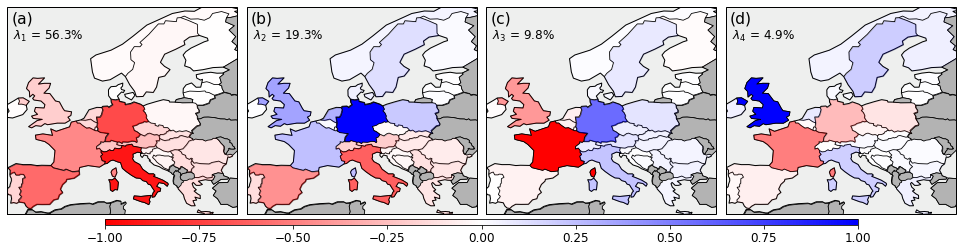

In [12]:
fig, ax = plt.subplots(figsize=(17, 4), nrows=1, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()})
linewidth = 0.8
panels = ['(a)', '(b)', '(c)', '(d)']
eigen_values = eig_val
eigen_vectors = eig_vec
variance_explained = []
for j in eigen_values:
     variance_explained.append((j/sum(eigen_values))*100)
variance_explained_cumulative = np.cumsum(variance_explained)
data_names = network.loads_t.p.columns
VT = pd.DataFrame(data=eigen_vectors, index=data_names)

for i in range(4):
    ax[i].add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, linewidth=linewidth)
    ax[i].coastlines(resolution='110m')
    ax[i].add_feature(cartopy.feature.OCEAN, facecolor=(0.78,0.8,0.78), alpha=0.30)
    ax[i].set_extent ((-9.5, 30.5, 35, 71), cartopy.crs.PlateCarree())
    europe_not_included = {'AD','AL','AX','BY','FO','GG','GI','IM','IS','JE','LI','MC','MD',
                           'ME','MK','MT','RU','SM','UA','VA','XK'}
    shpfilename = shpreader.natural_earth(resolution='110m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries_1 = reader.records()
    name_loop = 'start'
    PC_NO = i+1
    for country in countries_1:
        if country.attributes['REGION_UN'] == 'Europe' and country.attributes['ISO_A2'] not in europe_not_included:
            if country.attributes['NAME'] == 'Norway':
                name_loop = 'NO'
            elif country.attributes['NAME'] == 'France':
                name_loop = 'FR'                
            else:
                name_loop = country.attributes['ISO_A2']
            for country_PSA in VT.index.values:
                if country_PSA == name_loop:
                    color_value = VT.loc[country_PSA][PC_NO-1]
                    if color_value <= 0:
                        color_value = np.absolute(color_value)*1.5
                        ax[i].add_geometries([country.geometry], ccrs.PlateCarree(), linewidth=linewidth, facecolor=(1, 0, 0), 
                                             alpha=(np.min([color_value, 1])), edgecolor="black", label=country.attributes['ADM0_A3'])
                    else:
                        color_value = np.absolute(color_value)*1.5
                        ax[i].add_geometries([country.geometry], ccrs.PlateCarree(), linewidth=linewidth, facecolor=(0, 0, 1), 
                                             alpha=(np.min([color_value, 1])), edgecolor="black", label=country.attributes['ADM0_A3'])
        else:
            ax[i].add_geometries([country.geometry], ccrs.PlateCarree(),facecolor=(.7,.7,.7), alpha=1, linewidth=linewidth, 
                                 edgecolor="black", label=country.attributes['ADM0_A3'])

    ax[i].text(0.018, 0.92, panels[i], fontsize=15.5, transform=ax[i].transAxes);
    ax[i].text(0.026, 0.84, r'$\lambda_{'+ str(PC_NO) + '}$ = ' + str(round(variance_explained[PC_NO-1],1)) + '%', 
               fontsize=12, transform=ax[i].transAxes);

cmap = LinearSegmentedColormap.from_list('mycmap', [(1,0,0),(1,0.333,0.333),(1,0.666,0.666),'white',(0.666,0.666,1),(0.333,0.333,1),(0,0,1)])
shrink = 0.08
ax1 = fig.add_axes([0.125+shrink, 0.105, 0.775-shrink*2, 0.02])
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = ax1.figure.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax1, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
plt.subplots_adjust(hspace=0.02, wspace=0.04)

In [13]:
#file = 'postnetwork-elec_only_0.125_0.05.h5'
#network = pypsa.Network(directory+file)
#network.name = file
data_names = network.loads_t.p.columns
time_index = network.loads_t.p.index
prices = network.buses_t.marginal_price
country_price = prices[data_names] # [€/MWh]
nodal_price = country_price.values
nodal_price = pd.DataFrame(data=nodal_price, index=time_index, columns=data_names)
nodal_price = np.clip(nodal_price, 0, 1000)
eigen_values_prices, eigen_vectors_prices = PCA(nodal_price)[0:2]

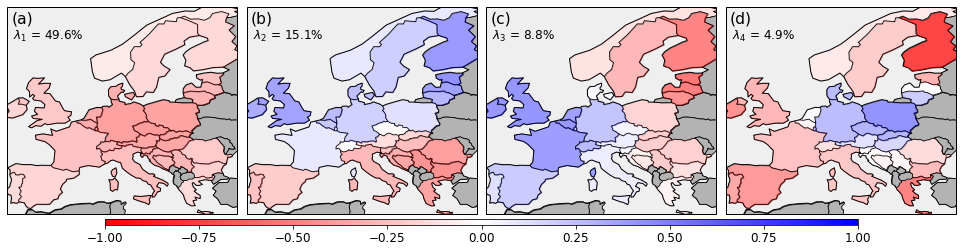

In [14]:
fig, ax = plt.subplots(figsize=(17, 4), nrows=1, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()})
linewidth = 0.8
panels = ['(a)', '(b)', '(c)', '(d)']
variance_explained_prices = []
for j in eigen_values_prices:
     variance_explained_prices.append((j/sum(eigen_values_prices))*100)
variance_explained_prices_cumulative = np.cumsum(variance_explained_prices)
data_names = network.loads_t.p.columns
VT_prices = pd.DataFrame(data=eigen_vectors_prices, index=data_names)

for i in range(4):
    ax[i].add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, linewidth=linewidth)
    ax[i].coastlines(resolution='110m')
    ax[i].add_feature(cartopy.feature.OCEAN, facecolor=(0.78,0.8,0.78), alpha=0.30)
    ax[i].set_extent ((-9.5, 30.5, 35, 71), cartopy.crs.PlateCarree())
    europe_not_included = {'AD','AL','AX','BY','FO','GG','GI','IM','IS','JE','LI','MC','MD',
                           'ME','MK','MT','RU','SM','UA','VA','XK'}
    shpfilename = shpreader.natural_earth(resolution='110m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries_1 = reader.records()
    name_loop = 'start'
    PC_NO = i+1
    for country in countries_1:
        if country.attributes['REGION_UN'] == 'Europe' and country.attributes['ISO_A2'] not in europe_not_included:
            if country.attributes['NAME'] == 'Norway':
                name_loop = 'NO'
            elif country.attributes['NAME'] == 'France':
                name_loop = 'FR'                
            else:
                name_loop = country.attributes['ISO_A2']
            for country_PSA in VT_prices.index.values:
                if country_PSA == name_loop:
                    #print("Match!")
                    color_value = VT_prices.loc[country_PSA][PC_NO-1]
                    #print(color_value)
                    if color_value <= 0:
                        # Color red
                        color_value = np.absolute(color_value)*1.5
                        ax[i].add_geometries([country.geometry], ccrs.PlateCarree(), linewidth=linewidth, facecolor=(1, 0, 0), 
                                               alpha=(np.min([color_value, 1])), edgecolor="black", label=country.attributes['ADM0_A3'])
                    else:
                        # Color blue
                        color_value = np.absolute(color_value)*1.5
                        ax[i].add_geometries([country.geometry], ccrs.PlateCarree(), linewidth=linewidth, facecolor=(0, 0, 1), 
                                               alpha=(np.min([color_value, 1])), edgecolor="black", label=country.attributes['ADM0_A3'])
        else:  
            ax[i].add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=(.7,.7,.7), alpha=1, linewidth=linewidth, 
                                   edgecolor="black", label=country.attributes['ADM0_A3'])

    ax[i].text(0.018, 0.92, panels[i], fontsize=15.5, transform=ax[i].transAxes);
    ax[i].text(0.026, 0.84, r'$\lambda_{'+ str(PC_NO) + '}$ = ' + str(round(variance_explained_prices[PC_NO-1],1)) + '%', 
                 fontsize=12, transform=ax[i].transAxes);

cmap = LinearSegmentedColormap.from_list('mycmap', [(1,0,0),(1,0.333,0.333),(1,0.666,0.666),'white',(0.666,0.666,1),(0.333,0.333,1),(0,0,1)])
shrink = 0.08
ax1 = fig.add_axes([0.125+shrink, 0.105, 0.775-shrink*2, 0.02])
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = ax1.figure.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax1, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
plt.subplots_adjust(hspace=0.02, wspace=0.04)

## Diurnal and seasonal behaviour

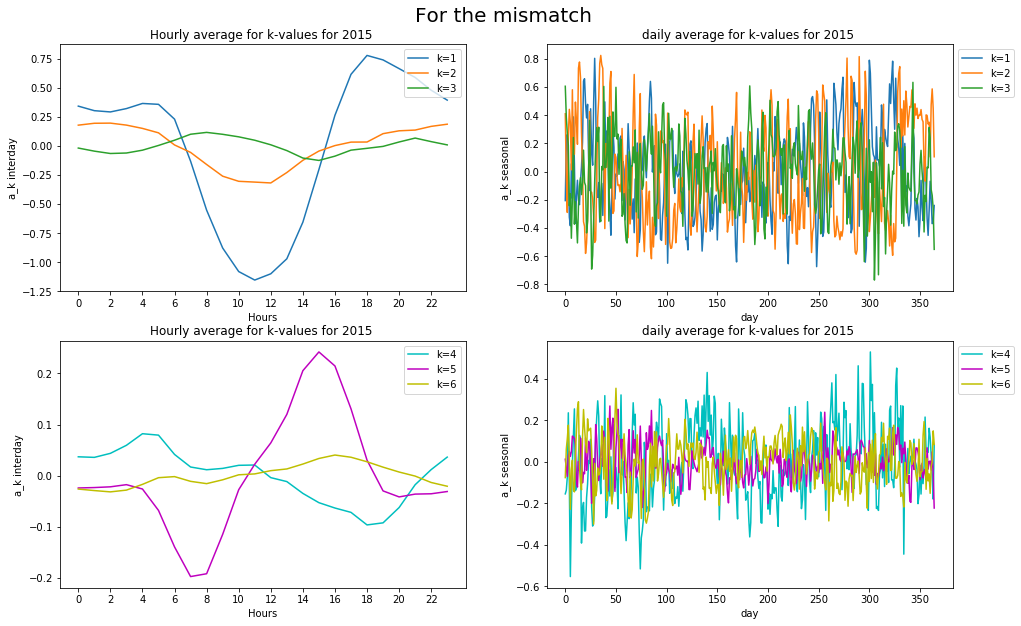

In [19]:
#%% PCA mismatch
eigen_values_mis, eigen_vectors_mis, variance_explained_mis, norm_const_mis, T_mis = PCA(mismatch)
T_mis = pd.DataFrame(data=T_mis,index=time_index)

# Season Plot Mismatch
season_plot(T_mis, time_index, 'For the mismatch')

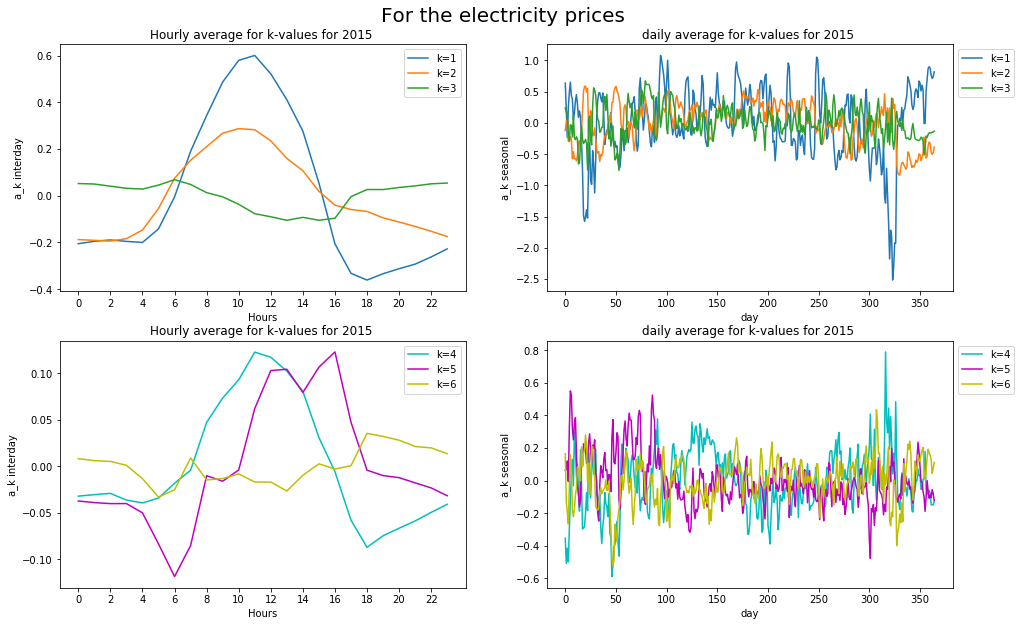

In [20]:
#%% PCA Electricity nodal price
eigen_values_ENP, eigen_vectors_ENP, variance_explained_ENP, norm_const_ENP, T_ENP = PCA(nodal_price)
T_ENP = pd.DataFrame(data=T_ENP,index=time_index)

# Season Plot Prices
season_plot(T_ENP, time_index, 'For the electricity prices')

## Fourier power spectra

/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in true_divide


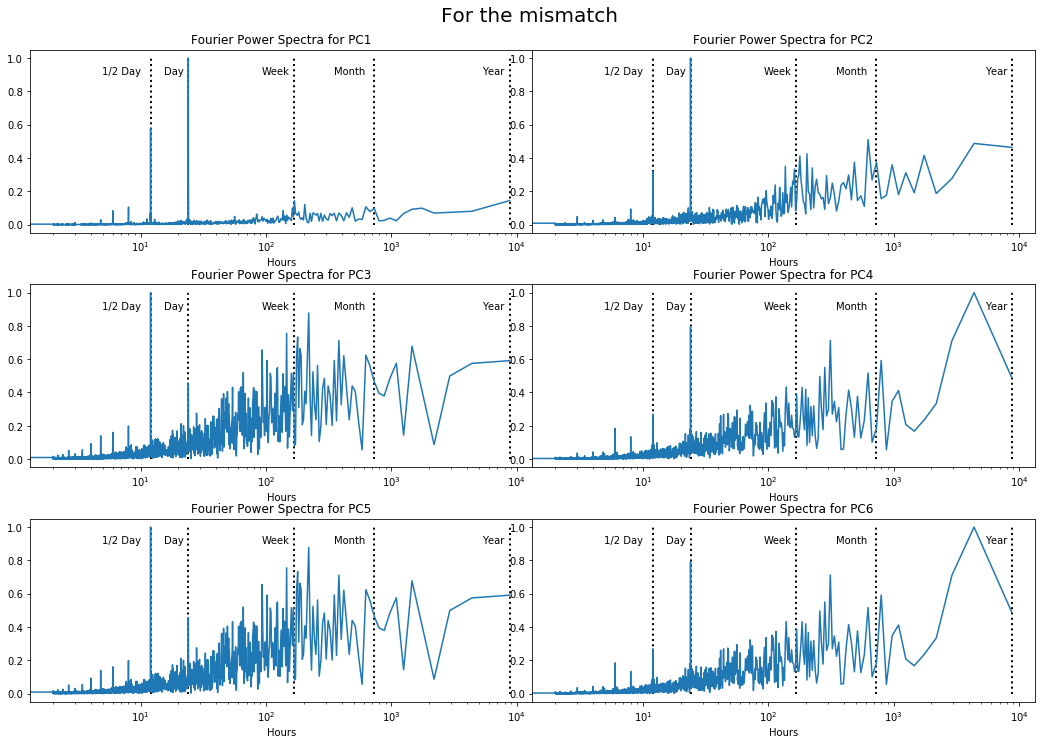

In [27]:
# FFT Plot
FFT_plot(T_mis, 'For the mismatch')

/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
/home/leonsn/anaconda3/envs/pypsa-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in true_divide


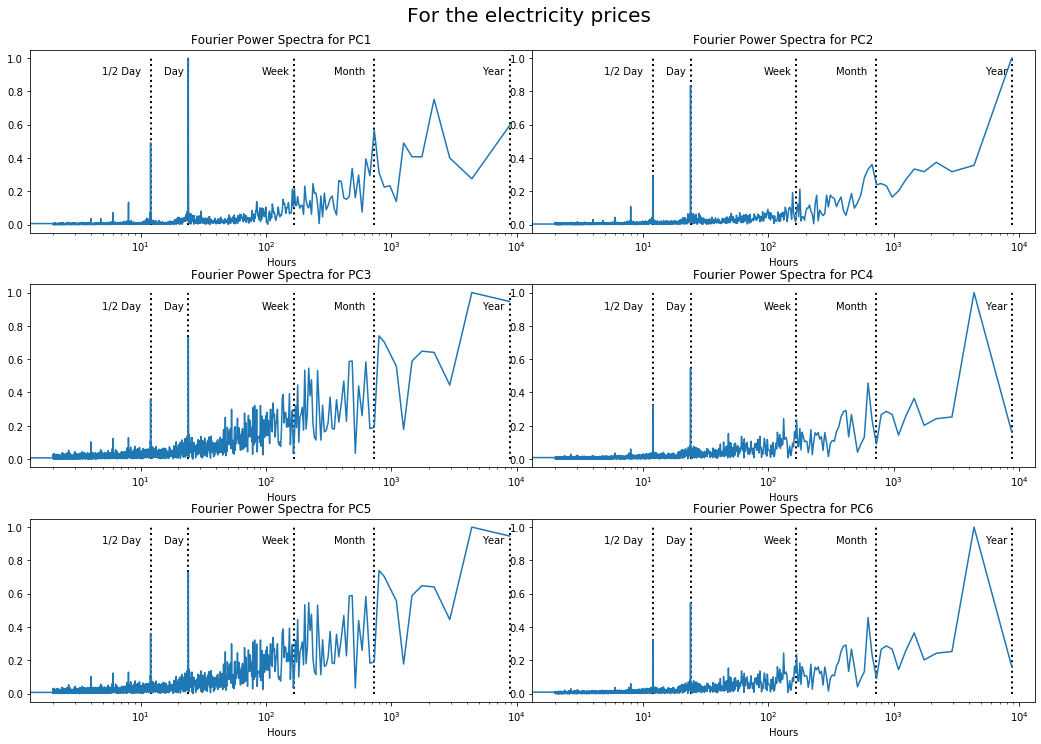

In [28]:
# FFT Plot
FFT_plot(T_ENP, 'For the electricity prices')